In [2]:
using PyPlot

In [64]:
x_data = collect(linspace(0., 10.))
y_data = zeros(length(x_data))
sigma = 10.0
y_error = ones(length(x_data))*sigma
for idx=1:length(x_data)
    dev = 2.*sigma*rand() - 1.0
    y_data[idx] = x_data[idx]^2 + dev
end

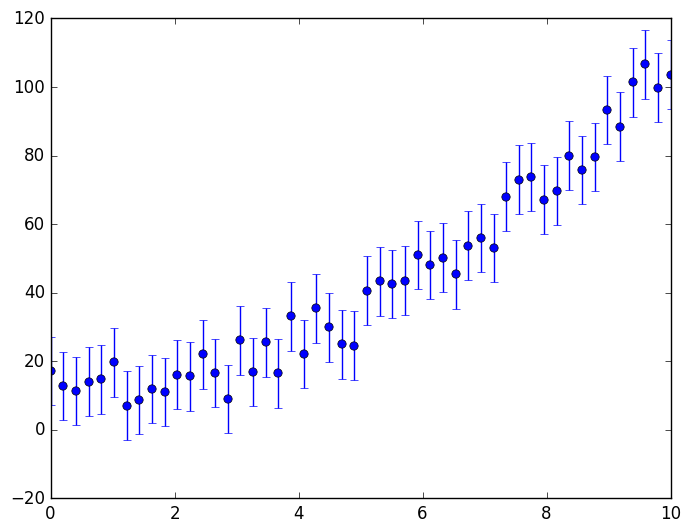

(PyObject <matplotlib.lines.Line2D object at 0x7f99cfa03f10>,(PyObject <matplotlib.lines.Line2D object at 0x7f99d2e41a90>,PyObject <matplotlib.lines.Line2D object at 0x7f99d2e71d50>),(PyObject <matplotlib.collections.LineCollection object at 0x7f99d2e414d0>,))

In [65]:
errorbar(x_data, y_data, y_error, fmt="o", label="Data")

In [66]:
function parabola_model(x, p)
    a = p[1]
    b = p[2]
    c = p[3]
    return a*x.^2 + b*x + c
end

parabola_model (generic function with 1 method)

In [67]:
lsq_fit_params = [1.2, 0.3, -0.2]
param_errors = [1.0, 1.0, 1.0]
y_model = zeros(length(x_data))
for idx=1:length(x_data)
    y_model[idx] = parabola_model(x_data[idx], lsq_fit_params)
end

chi_best = sum(((y_data-y_model)/y_error)^2)

1.4612533686303784

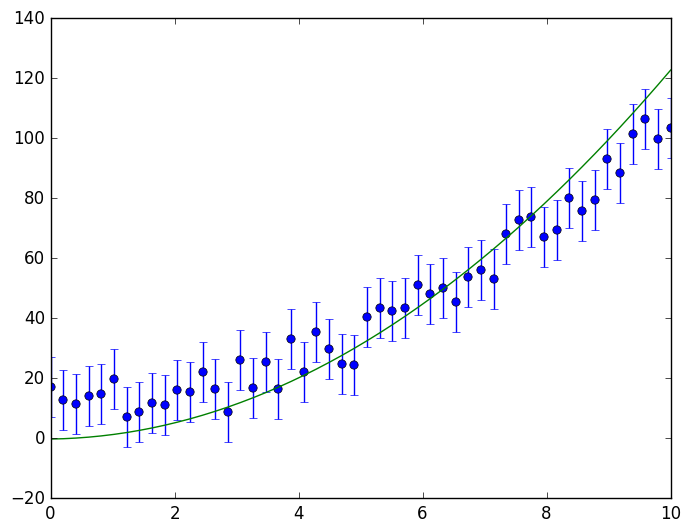

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f99cf8c9910>

In [68]:
errorbar(x_data, y_data, y_error, fmt="o", label="Data")
plot(x_data,y_model)

In [27]:
"""
# Finds the best fit paramaters for a model using an 
# affine-invariant markov chain:
# Foreman-Mackey et al. (2014) - 'emc' 'mcmc hammer'
#
# Input:
#           model: A function to model the data
#               x: The x values of the data
#               y: The y values of the data
#         y_error: Y value error bars
#  lsq_fit_params: Best fit parameters from doing a
#                  least squares fit
#    param_errors: Errors on the least squares fit  parameters
#        chi_best: Chi squared value from least squares fit
#
# Output:
#   param_mean: Mean value of the parameters found using MCMC
#    param_std: Standard deviation of the mean values
"""
function mcmc_fit!(model, x::Vector, y::Vector, y_error::Vector, lsq_fit_params::Vector, 
                   param_errors::Vector, chi_best::Float64, param_mean::Vector, param_std::Vector, )  
    nparam = length(lsq_fit_params)
    nwalkers = nparam * 3
    nsteps = 1000
    # Set up arrays to hold the results:
    par_mcmc = zeros(nwalkers,nsteps,nparam)
    chi_mcmc = zeros(nwalkers,nsteps)
    # Initialize walkers:
    par_trial = lsq_fit_params
    for j=1:nwalkers
        # Select from within uncertainties:
        chi_trial = 1e100
        # Only initiate models with reasonable chi-square values:
        while chi_trial > (chi_best + 1000)
            par_trial = lsq_fit_params + param_errors.*randn(nparam)
            y_model = model(x, par_trial)
            chi_trial = sum(((y-y_model)./y_error).^2)
        end
        chi_mcmc[j,1]=chi_trial
        par_mcmc[j,1,:]=par_trial
        println("Success: ",par_trial,chi_trial)
    end
    
    # Initialize scale length & acceptance counter:
    ascale = 2.0
    accept = 0
    # Next, loop over steps in markov chain:
    for i=2:nsteps
        for j=1:nwalkers
            ipartner = j
            # Choose another walker to 'breed' a trial step with:
            while ipartner == j
                ipartner = ceil(Int,rand()*nwalkers)
            end
            # Now, choose a new set of parameters for the trial step:
            z=(rand()*(sqrt(ascale)-1.0/sqrt(ascale))+1.0/sqrt(ascale))^2
            par_trial=vec(z*par_mcmc[j,i-1,:]+(1.0-z)*par_mcmc[ipartner,i-1,:])
            # Compute model & chi-square:    
            y_model_trial = model(x,par_trial)
            chi_trial = sum(((y-y_model_trial)./y_error).^2)
            # Next, determine whether to accept this trial step:
            alp = z^(nparam-1)*exp(-0.5*(chi_trial - chi_mcmc[j,i-1]))
            if alp >= rand()
                # If step is accepted, add it to the chains!
                par_mcmc[j,i,:] = par_trial
                chi_mcmc[j,i,:] = chi_trial
                accept = accept + 1
            else
                # If step is rejected, then copy last step:
                par_mcmc[j,i,:] = par_mcmc[j,i-1,:]
                chi_mcmc[j,i,:] = chi_mcmc[j,i-1]
            end
        end
        if mod(i,1000) == 0
            frac_acc = accept/(1000*nwalkers)
            println("Number of steps: ",i," acceptance rate: ",frac_acc)
            ascale = 1.0 + (frac_acc/0.25)*(ascale-1.0)
            accept = 0
        end
    end
    
    # Now, determine time of burn-in by calculating first time median is crossed:
    iburn = 0
    for i=1:nparam
      med_param=median(par_mcmc[1:nwalkers,1:nsteps,i])
      for j=1:nwalkers
        istep=2
        while (par_mcmc[j,istep,i] > med_param) == (par_mcmc[j,istep-1,i] > med_param) && (istep < nsteps)
          istep=istep+1
        end
        if istep >= iburn
          iburn = istep
        end
      end
    end

    println("Burn-in ends: ",iburn)
    
    for i=1:nparam
        param_mean[i] = mean(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]))
        param_std[i] = std(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]))
    end
    return par_mcmc
end

mcmc_fit! (generic function with 1 method)

In [4]:
param = zeros(length(lsq_fit_params))
stdev = zeros(length(lsq_fit_params))

fit = mcmc_fit!(parabola_model, x_data, y_data, y_error, lsq_fit_params, param_errors, chi_best, param, stdev)
@printf "a: %8.4f +/- %8.4f\n" param[1] stdev[1]
@printf "b: %8.4f +/- %8.4f\n" param[2] stdev[2]
@printf "c: %8.4f +/- %8.4f\n" param[3] stdev[3]

LoadError: LoadError: UndefVarError: lsq_fit_params not defined
while loading In[4], in expression starting on line 1

In [71]:
y_model_mcmc = zeros(length(x_data))
for idx=1:length(x_data)
    y_model_mcmc[idx] = parabola_model(x_data[idx], [param[1], param[2], param[3]])
end

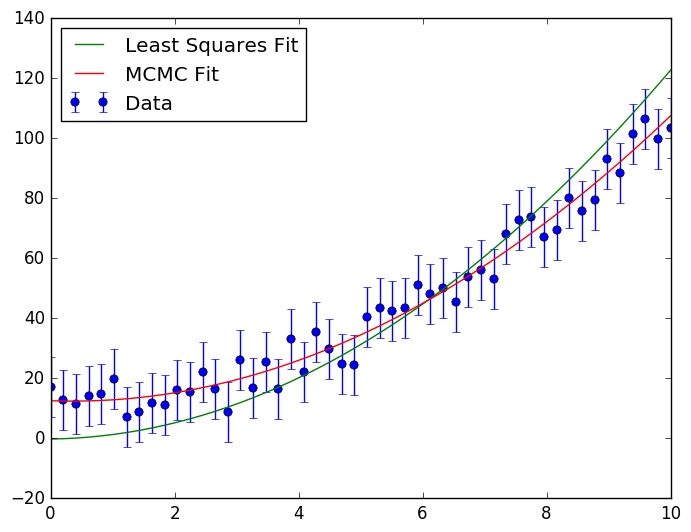

PyObject <matplotlib.legend.Legend object at 0x7f99d2db6650>

In [72]:
errorbar(x_data, y_data, y_error, fmt="o", label="Data")
plot(x_data, y_model, label="Least Squares Fit")
plot(x_data, y_model_mcmc, label="MCMC Fit")
legend(loc=2)

In [9]:
# Required packages
using LsqFit
using PyPlot
include("../compute_ttv.jl")
include("../ttv_succinct.jl")

ttv_succinct! (generic function with 1 method)

In [10]:
# Load transit timing data
transit_time1 = readdlm("../ttv_planet1.txt")[:,1]
transit_time2 = readdlm("../ttv_planet2.txt")[:,1]

#transit_time1 .-= transit_time1[1]
#transit_time2 .-= transit_time2[2]

24-element Array{Float64,1}:
  8461.76
  8827.02
  9192.27
  9557.53
  9922.79
 10288.0 
 10653.3 
 11018.6 
 11383.8 
 11749.1 
 12114.3 
 12479.6 
 12844.8 
 13210.1 
 13575.4 
 13940.6 
 14305.9 
 14671.1 
 15036.4 
 15401.6 
 15766.9 
 16132.1 
 16497.4 
 16862.7 

In [2]:
"""
# Calculates the total TTV at each time point for a
# set of planets.
#
# Input:
#   transit_time: A vector, with each element containing
#                 an array of transit times for one planet
#           pl: A vector of Planet_plane_hk objects
#
# Returns:
#   A vector, with each element containing the TTV offset
#   at every time point for the given planets
"""

function calc_ttv_total(transit_time::Vector, pl::Vector)
    N = length(pl)
    jmax = 20
    
    ttv_total = []
    for i=1:N
        append!(ttv_total, zeros(transit_time[i])) 
    end
    
    for i=1:N
        for j=(i+1):N
            ttv_i = zeros(length(transit_time[i]))
            ttv_j = zeros(length(transit_time[j]))
            TTVFaster.compute_ttv!(jmax, pl[i], pl[j], transit_time[i], transit_time[j], ttv_i, ttv_j)
            ttv_total[i] .+= ttv_i
            ttv_total[j] .+= ttv_j
        end
    end
    
    return ttv_total
end

calc_ttv_total (generic function with 1 method)

In [11]:
# Find approximate period from transit data
sum1 = 0.0
sum1a = 0.0
sum2 = 0.0
sum2a = 0.0
for i in 1:(length(transit_time1)-1)
    sum1 += transit_time1[i+1] - transit_time1[i]
end

Per1 = sum1 / (length(transit_time1)-1)

for i in 1:(length(transit_time1)-1)
    sum1a += (transit_time1[i+1] - transit_time1[i] - Per1)^2
end

for i in 1:(length(transit_time2)-1)
    sum2 += transit_time2[i+1] - transit_time2[i]
end


Per2 = sum2 / (length(transit_time2)-1)

for i in 1:(length(transit_time2)-1)
    sum2a += (transit_time2[i+1] - transit_time2[i] - Per2)^2
end

Stdev1 = sqrt(sum1a/(length(transit_time1)-1))
Stdev2 = sqrt(sum2a/(length(transit_time2)-1))

Per1,Per2,Stdev1,Stdev2

(224.70076641863517,365.25630708152175,0.0022543542095608466,0.0021310026275067444)

In [12]:
function timing_model_2p(x, p)
    m_rat1 = p[1]
    period1 = p[2]
    t01 = p[3]
    ecosw1 = p[4]
    esinw1 = p[5]
    
    m_rat2 = p[6]
    period2 = p[7]
    t02 = p[8]
    ecosw2 = p[9]
    esinw2 = p[10]
    
        # Mass ratios must be larger than zero
    if ((m_rat1 > 0.) && (m_rat2 > 0.) &&
        # Inner planets must have smaller periods
        (period1 > 0.) && (period1 < period2) &&
        # Keep periods within 1 standard deviation of the guess
        ((Per1 - 2.*Stdev1) < period1 < (Per1 + 2.*Stdev1)) &&
        ((Per1 - 2.*Stdev2) < period2 < (Per2 + 2.*Stdev2)) &&
        # Restruct ecc vector to be between -1 and 1 (and not 0)
        (ecosw1 != 0.) && (esinw1 != 0.) && (ecosw2 != 0.) && (esinw2 != 0.) &&
        (ecosw1 > -1.) && (esinw1 > -1.) && (ecosw2 > -1.) && (esinw2 > -1.) &&
        (ecosw1 < 1.) && (esinw1 < 1.) && (ecosw2 < 1.) && (esinw2 < 1.))
    
        t1 = collect(linspace(t01, t01 + period1*length(transit_time1), length(transit_time1)))
        t2 = collect(linspace(t02, t02 + period2*length(transit_time2), length(transit_time2)))
        
        pl = Array(TTVFaster.Planet_plane_hk{Float64}, 2)
        pl[1] = TTVFaster.Planet_plane_hk{Float64}(m_rat1, period1, t01, ecosw1, esinw1)
        pl[2] = TTVFaster.Planet_plane_hk{Float64}(m_rat2, period2, t02, ecosw2, esinw2)

        ttv_total = calc_ttv_total(Vector{Float64}[t1, t2], pl)
        
        t1 .+= ttv_total[1]
        t2 .+= ttv_total[2]

        retarr = collect([t1, t2])
        return retarr
    end

    t1 = collect(linspace(t01, t01 + period1*length(transit_time1), length(transit_time1)))
    t2 = collect(linspace(t02, t02 + period2*length(transit_time2), length(transit_time2)))
    retarr = zeros(length(t1)+length(t2))#collect([t1, t2])
    retarr[:] = typemax(Float64)
    return retarr
end

timing_model_2p (generic function with 1 method)

In [13]:
p = [1e-4, Per1, transit_time1[1], 0.05, 0.25,
    1e-4, Per2, transit_time2[1], 0.05, 0.05]

y = collect([transit_time1, transit_time2])
x = collect(linspace(1,length(y),length(y)))
weight = Array(Float64,length(y))
errorbars = Array(Float64,length(y))
weight[:] = (30.0/86400.0)^-2.
errorbars[:] = 30.0/86400.0
fit = curve_fit(timing_model_2p, x, y ,weight, p)
fit.param

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:32
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/linc/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /home/linc/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading In[13], in expression starting on line 4
 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:32
 in timing_model_2p at In[12]:38
 in f at /home/linc/.julia/v0.4/LsqFit/src/curve_fit.jl:45
 in levenberg_marquardt at /home/linc/.julia/v0.4/Optim/src/levenberg_marquardt.jl:38
 in lmfit at /home/linc/.julia/v0.4/LsqFit/src/curve_fit.jl:29
 in curve_fit at /home/linc/.julia/v0.4/LsqFit/src/curve_fit.jl:46
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/linc/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /home/linc/.julia/v0.4/IJulia/src/IJulia

10-element Array{Float64,1}:
    0.000101218
  224.697      
 8445.43       
    0.0477312  
    0.253721   
    0.000103797
  365.247      
 8461.65       
    0.0515788  
    0.047198   

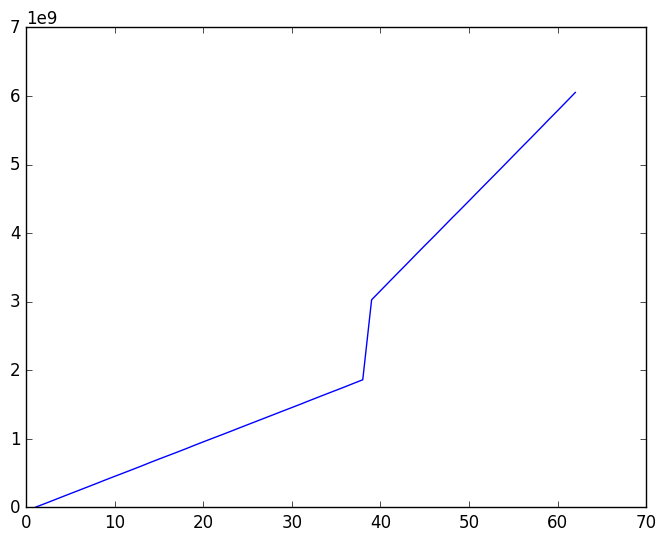

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe963b35490>

In [18]:
resid = fit.resid
x = collect(linspace(1., length(resid), length(resid)))
plot(x, resid)

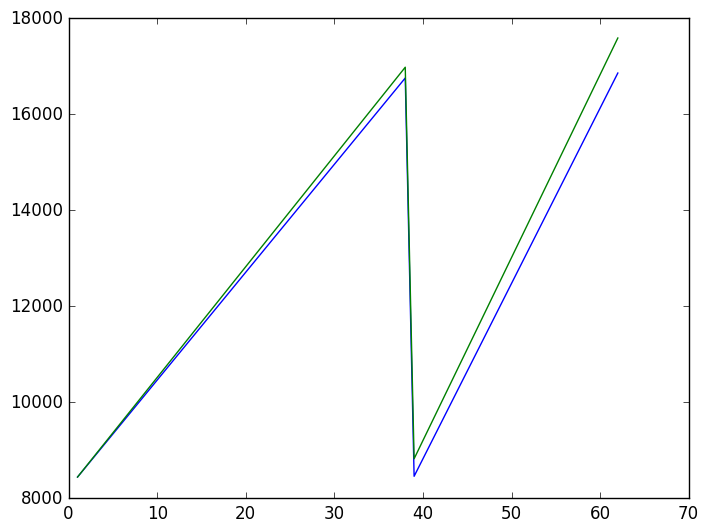

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe963afbe50>

In [19]:
x = collect(linspace(1., length(resid), length(resid)))
plot(x, collect([transit_time1, transit_time2]))

y_model = timing_model_2p(x, fit.param)
plot(x, y_model)

In [20]:
function timing_model_3p_fixed_p3(x, p)
    m_rat1 = p[1]
    period1 = p[2]
    t01 = p[3]
    ecosw1 = p[4]
    esinw1 = p[5]
    
    m_rat2 = p[6]
    period2 = p[7]
    t02 = p[8]
    ecosw2 = p[9]
    esinw2 = p[10]
    
    m_rat3 = p[11]
    t03 = p[12]
    ecosw3 = p[13]
    esinw3 = p[14]
    
        # Mass ratios must be larger than zero
    if ((m_rat1 > 0.) && (m_rat2 > 0.) && (m_rat3 > 0.) &&
        # Inner planets must have smaller periods
        (period1 > 0.) && (period1 < period2) && (period2 < Period3) &&
        # Keep periods within 1 standard deviation of the guess
        ((Per1 - 2.*Stdev1) < period1 < (Per1 + 2.*Stdev1)) &&
        ((Per1 - 2.*Stdev2) < period2 < (Per2 + 2.*Stdev2)) &&
        # Restruct ecc vector to be between -1 and 1 (and not 0)
        (ecosw1 != 0.) && (esinw1 != 0.) && (ecosw2 != 0.) && (esinw2 != 0.) && (ecosw3 != 0. && esinw3 != 0.) &&
        (ecosw1 > -1.) && (esinw1 > -1.) && (ecosw2 > -1.) && (esinw2 > -1.) && (ecosw3 > -1. && esinw3 > -1.) &&
        (ecosw1 < 1.) && (esinw1 < 1.) && (ecosw2 < 1.) && (esinw2 < 1.) && (ecosw3 < 1. && esinw3 < 1.))
    
        t1 = collect(linspace(t01, t01 + period1*length(transit_time1), length(transit_time1)))
        t2 = collect(linspace(t02, t02 + period2*length(transit_time2), length(transit_time2)))
        t3 = collect(linspace(0., Period3*10., 10))
        
        pl = Array(TTVFaster.Planet_plane_hk{Float64}, 3)
        pl[1] = TTVFaster.Planet_plane_hk{Float64}(m_rat1, period1, t01, ecosw1, esinw1)
        pl[2] = TTVFaster.Planet_plane_hk{Float64}(m_rat2, period2, t02, ecosw2, esinw2)
        pl[3] = TTVFaster.Planet_plane_hk{Float64}(m_rat3, Period3, t03, ecosw3, esinw3)

        ttv_total = calc_ttv_total(Vector{Float64}[t1, t2, t3], pl)
        
        t1 .+= ttv_total[1]
        t2 .+= ttv_total[2]

        retarr = collect([t1, t2])
        return retarr
    end

    retarr = zeros(length(transit_time1)+length(transit_time2))
    retarr[:] = typemax(Float64)
    return retarr
end

timing_model_3p_fixed_p3 (generic function with 1 method)

In [95]:
#periods = collect(linspace(4310.0,4340.0,30))
#periods = [4329.]
periods = collect(linspace(500.,10000.,95))
chisq = zeros(Float64,length(periods))
fits = Array(Any,length(periods))

p = [1e-4, Per1, transit_time1[1], 0.01, 0.01,
    1e-4, Per2, transit_time2[2], 0.01, 0.01,
    1e-1,      transit_time1[1], 0.01, 0.01]

for i=1:length(periods)
    global Period3 = periods[i]
    transit_time3 = collect(linspace(transit_time1[1], periods[i]*10., 10))

    y = collect([transit_time1, transit_time2])
    x = collect(linspace(1,length(y),length(y)))
    weight = Array(Float64,length(y))
    errorbars = Array(Float64,length(y))
    weight[:] = (30.0/86400.0)^(-2.)
    errorbars[:] = 30.0/86400.0
    fit = curve_fit(timing_model_3p_fixed_p3, x, y ,weight, p)
    fits[i] = fit
    
    chisq[i] = sum((fit.resid/errorbars)^2.)
end

In [96]:
fits[indmin(chisq)].param

14-element Array{Float64,1}:
    9.03807e-5
  224.7       
 8445.48      
    0.00994008
    0.0100182 
    9.92038e-5
  365.258     
 8827.04      
    0.0100014 
    0.00999838
    0.100069  
 8445.48      
    0.00999649
    0.0100099 

In [97]:
indmin(chisq)

3

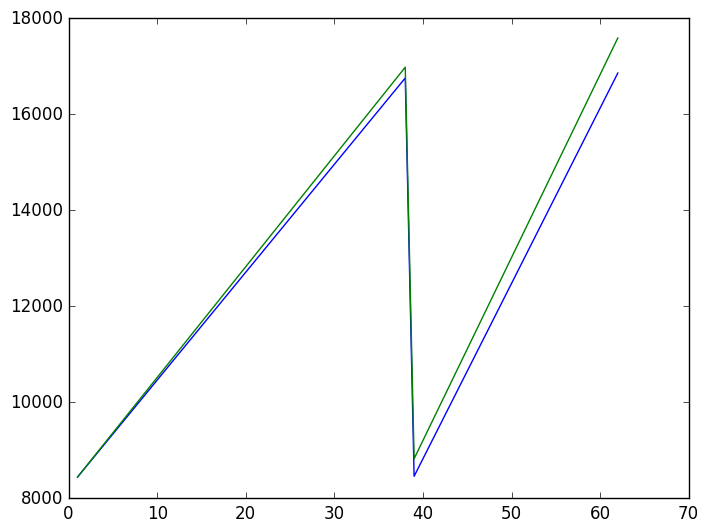

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe95df01a90>

In [101]:
x = collect(linspace(1., length(resid), length(resid)))
plot(x, collect([transit_time1, transit_time2]))

Period3 = periods[indmin(chisq)]
Period3 = 4329.0
y_model = timing_model_3p_fixed_p3(x, fits[indmin(chisq)].param)
plot(x, y_model)

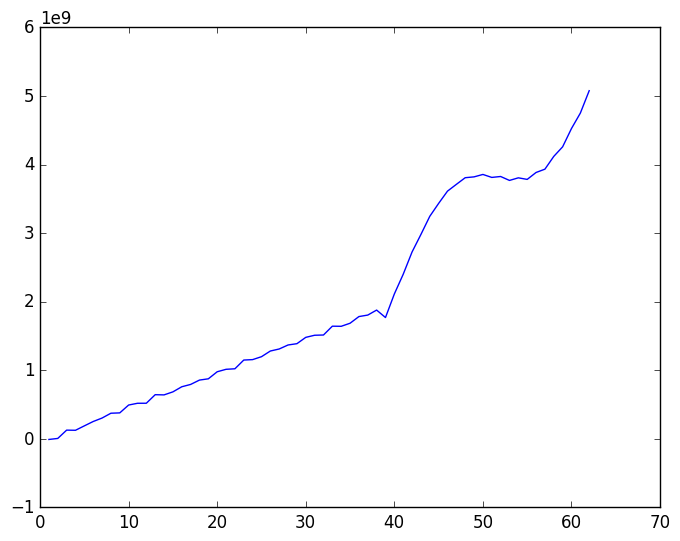

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe95daf7390>

In [102]:
resid = fits[indmin(chisq)].resid
x = collect(linspace(1., length(resid), length(resid)))
plot(x, resid)

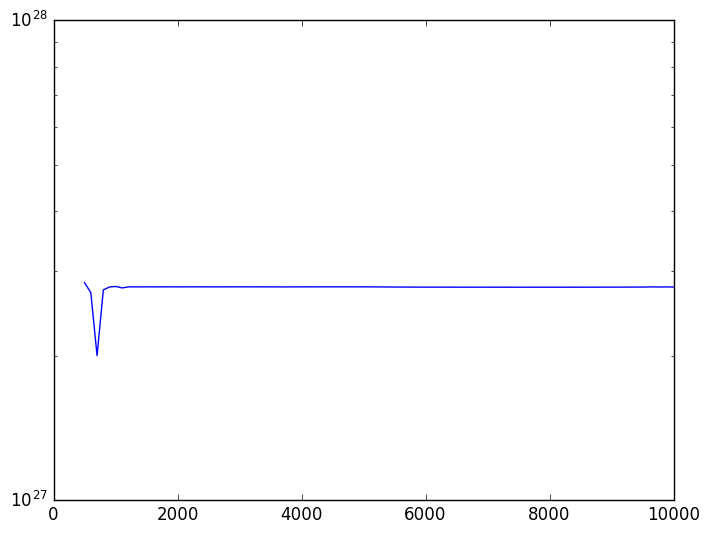

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe95da70590>

In [103]:
semilogy(periods,chisq)

In [26]:
function timing_model_3p(x, p)
    m_rat1 = p[1]
    period1 = p[2]
    t01 = p[3]
    ecosw1 = p[4]
    esinw1 = p[5]
    
    m_rat2 = p[6]
    period2 = p[7]
    t02 = p[8]
    ecosw2 = p[9]
    esinw2 = p[10]
    
    m_rat3 = p[11]
    period3 = p[12]
    t03 = p[13]
    ecosw3 = p[14]
    esinw3 = p[15]
    
        # Mass ratios must be larger than zero
    if ((m_rat1 > 0.) && (m_rat2 > 0.) && (m_rat3 > 0.) &&
        # Inner planets must have smaller periods
        (period1 > 0.) && (period1 < period2) && (period2 < period3) &&
        # Keep periods within 1 standard deviation of the guess
        ((Per1 - 2.*Stdev1) < period1 < (Per1 + 2.*Stdev1)) &&
        ((Per1 - 2.*Stdev2) < period2 < (Per2 + 2.*Stdev2)) &&
        # Restruct ecc vector to be between -1 and 1 (and not 0)
        (ecosw1 != 0.) && (esinw1 != 0.) && (ecosw2 != 0.) && (esinw2 != 0.) && (ecosw3 != 0. && esinw3 != 0.) &&
        (ecosw1 > -1.) && (esinw1 > -1.) && (ecosw2 > -1.) && (esinw2 > -1.) && (ecosw3 > -1. && esinw3 > -1.) &&
        (ecosw1 < 1.) && (esinw1 < 1.) && (ecosw2 < 1.) && (esinw2 < 1.) && (ecosw3 < 1. && esinw3 < 1.))
    
        t1 = collect(linspace(t01, t01 + period1*length(transit_time1), length(transit_time1)))
        t2 = collect(linspace(t02, t02 + period2*length(transit_time2), length(transit_time2)))
        t3 = collect(linspace(t03, t03 + Period3*10., 10))
        
        pl = Array(TTVFaster.Planet_plane_hk{Float64}, 3)
        pl[1] = TTVFaster.Planet_plane_hk{Float64}(m_rat1, period1, t01, ecosw1, esinw1)
        pl[2] = TTVFaster.Planet_plane_hk{Float64}(m_rat2, period2, t02, ecosw2, esinw2)
        pl[3] = TTVFaster.Planet_plane_hk{Float64}(m_rat3, period3, t03, ecosw3, esinw3)

        ttv_total = calc_ttv_total(Vector{Float64}[t1, t2, t3], pl)
        
        t1 .+= ttv_total[1]
        t2 .+= ttv_total[2]

        retarr = collect([t1, t2])
        return retarr
    end

    retarr = zeros(length(transit_time1)+length(transit_time2))
    retarr[:] = typemax(Float64)
    return retarr
end

timing_model_3p (generic function with 1 method)

In [123]:
y = collect([transit_time1, transit_time2])
x = collect(linspace(1, length(y), length(y)))

y_error = Array(Float64,length(y))
y_error[:] = 30.0/86400.0

lsq_fit_params = fits[indmin(chisq)].param
lsq_fit_params_15 = zeros(15)

for i=1:14
    if i < 12
        lsq_fit_params_15[i] = lsq_fit_params[i]
        elseif i > 12
            lsq_fit_params_15[i+1] = lsq_fit_params[i]
        end
end

lsq_fit_params_15[12] = 4329.0 #periods[indmin(chisq)]

param_errors = [0.1, 0.1, 1.0, 0.01, 0.01, 0.1, 0.1, 1.0, 0.01, 0.01, 0.01, 1.0, 250.0, 1.0, 1.0]
chi_best = chisq[indmin(chisq)]

param_mean = zeros(15)
param_std = zeros(15)

mcmc1 = mcmc_fit!(timing_model_3p, x, y, y_error, lsq_fit_params_15, param_errors, chi_best, param_mean, param_std)

Success: [0.010342881931331312,224.69639232959133,8445.53986590005,0.017092620297328272,0.009970551861524823,0.030638021214340165,365.15694166436697,8828.416038817993,0.009980700120271089,0.010580348669367422,0.11322473261425677,4328.5858447179435,121.28943719347568,-0.787087937924113,0.5361881392726491]6.782816667641355e13
Success: [0.05709773500308537,224.69966362399023,8445.238234638618,0.007237099246495191,-0.017997222183667828,0.05465552816739806,365.18417984678456,8826.439840923686,0.010068582410328306,-0.0033817310163110625,0.10984209080900861,4329.703715572109,-293.68377716473,0.5450202560828521,-0.25350691846016]6.847071886031586e13
Success: [0.013693227769362874,224.70476709335463,8446.37538299374,0.007758429649254603,0.004082044886776513,0.1587370480314518,365.2130511134804,8827.555864178203,0.007777290337284349,0.01011762994885833,0.09655706155394897,4327.948983703462,39.414257359976204,-0.2740877241778522,-0.05701710533474627]7.069534955405119e13
Success: [0.08155252616493

45x1000x15 Array{Float64,3}:
[:, :, 1] =
 0.0103429   0.0103429   0.0103429   …  0.05712    0.05712    0.05712  
 0.0570977   0.0570977   0.0570977      0.0575012  0.0573171  0.0575016
 0.0136932   0.0136932   0.0209927      0.0573155  0.0574172  0.0574172
 0.0815525   0.0745201   0.0745201      0.0571892  0.0573506  0.0573506
 0.02494     0.02494     0.02494        0.0572145  0.0572145  0.0572145
 0.0705556   0.0705556   0.0698243   …  0.058576   0.058576   0.0589879
 0.0460696   0.0460696   0.0460696      0.0570736  0.0570736  0.0570523
 0.0965158   0.0965158   0.0965158      0.0575932  0.05733    0.0572546
 0.143489    0.143489    0.134046       0.0570946  0.0570946  0.0570946
 0.0256163   0.0256163   0.0256163      0.0573835  0.0573835  0.057079 
 0.0511341   0.0534163   0.0534163   …  0.0566056  0.0566056  0.0566056
 0.00216418  0.00216418  0.00216418     0.0574472  0.0574472  0.057477 
 0.0451034   0.0451034   0.0451034      0.056964   0.056964   0.0570958
 ⋮                     

In [124]:
param_mean

15-element Array{Float64,1}:
     0.0330482
   224.701    
  8491.24     
     0.251748 
    -0.365089 
     0.0291765
   365.157    
  8762.05     
     0.253231 
    -0.251599 
     0.256058 
  4333.77     
 15194.6      
     0.0710106
    -0.830545 

In [125]:
param_std

15-element Array{Float64,1}:
    0.0154054
    0.0029075
   18.4613   
    0.0999347
    0.0670547
    0.0145709
    0.0997412
   16.4306   
    0.0454607
    0.0492406
    0.227134 
   18.5823   
 1337.93     
    0.636806 
    0.12023  

In [126]:
size(mcmc)

(45,1000,15)

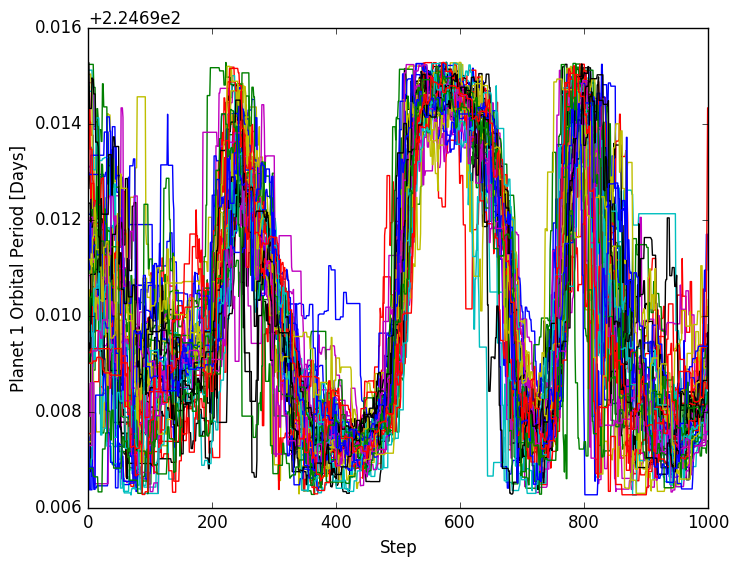

PyObject <matplotlib.text.Text object at 0x7fe95c02e110>

In [127]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,2]')
end
xlabel("Step")
ylabel("Planet 1 Orbital Period [Days]")

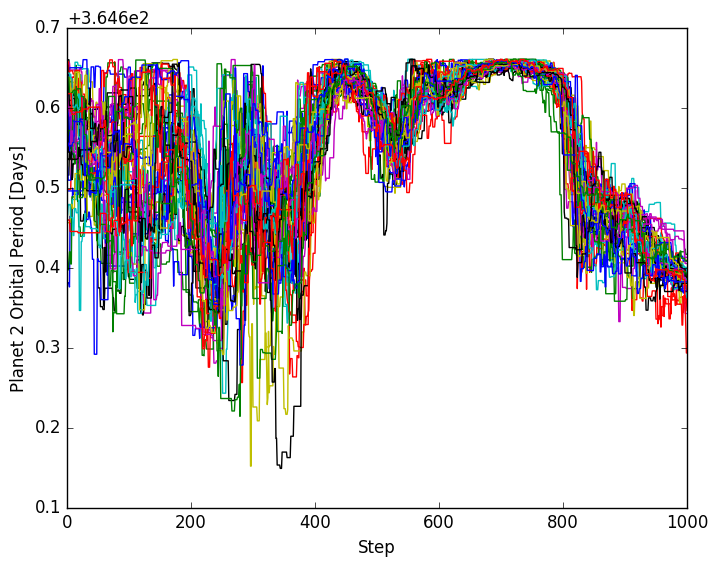

PyObject <matplotlib.text.Text object at 0x7fe95be38790>

In [128]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,7]')
end
xlabel("Step")
ylabel("Planet 2 Orbital Period [Days]")

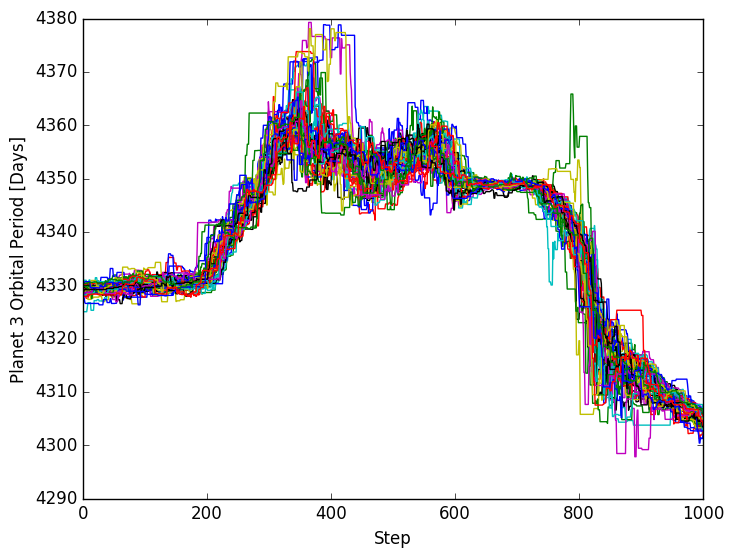

PyObject <matplotlib.text.Text object at 0x7fe95bccac90>

In [129]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,12]')
end
xlabel("Step")
ylabel("Planet 3 Orbital Period [Days]")

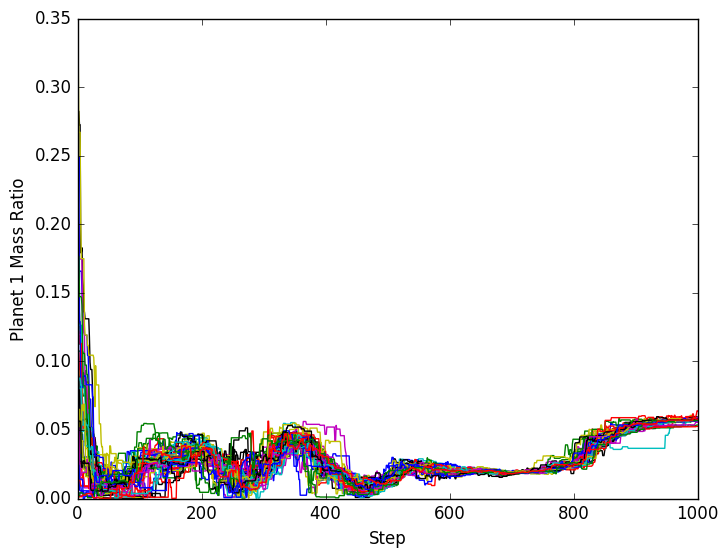

PyObject <matplotlib.text.Text object at 0x7fe95cda7810>

In [130]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,1]')
end
xlabel("Step")
ylabel("Planet 1 Mass Ratio")

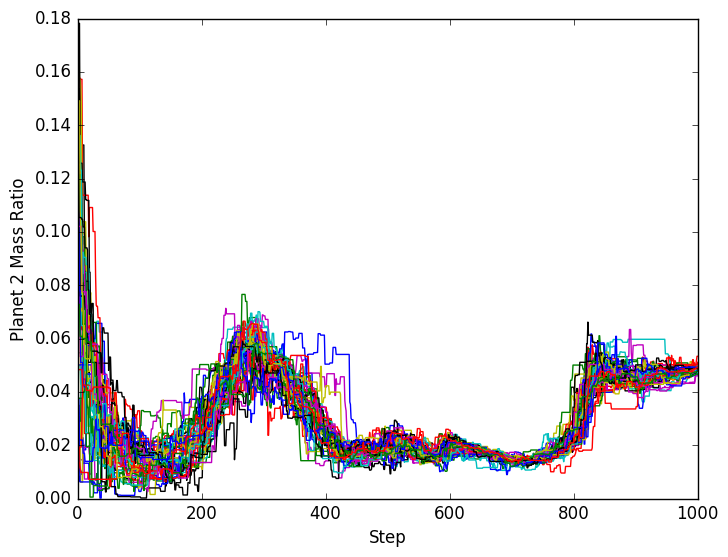

PyObject <matplotlib.text.Text object at 0x7fe95b9ae850>

In [131]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,6]')
end
xlabel("Step")
ylabel("Planet 2 Mass Ratio")

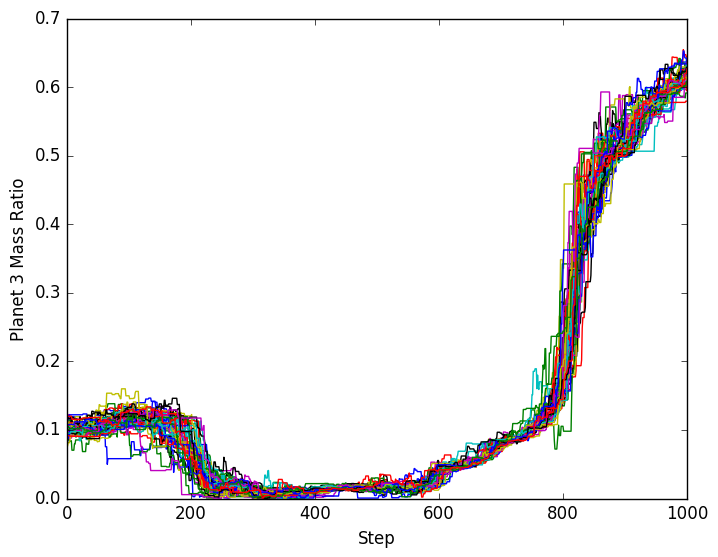

PyObject <matplotlib.text.Text object at 0x7fe95b7de510>

In [132]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,11]')
end
xlabel("Step")
ylabel("Planet 3 Mass Ratio")

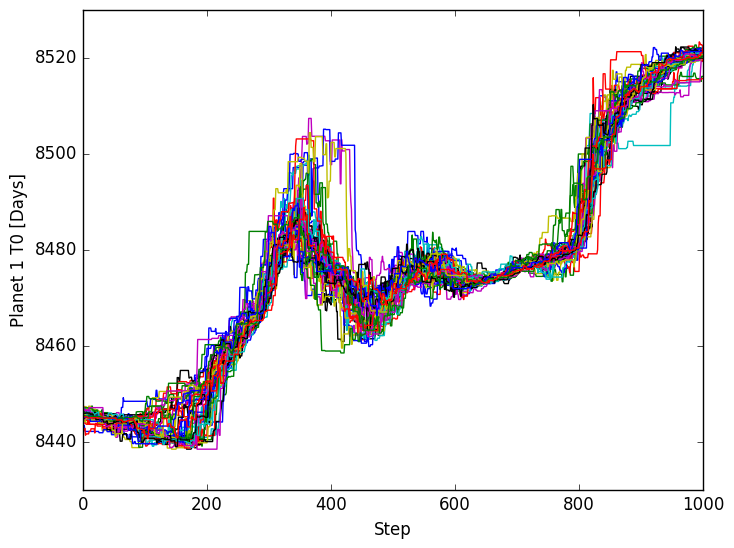

PyObject <matplotlib.text.Text object at 0x7fe95b605650>

In [133]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,3]')
end
xlabel("Step")
ylabel("Planet 1 T0 [Days]")

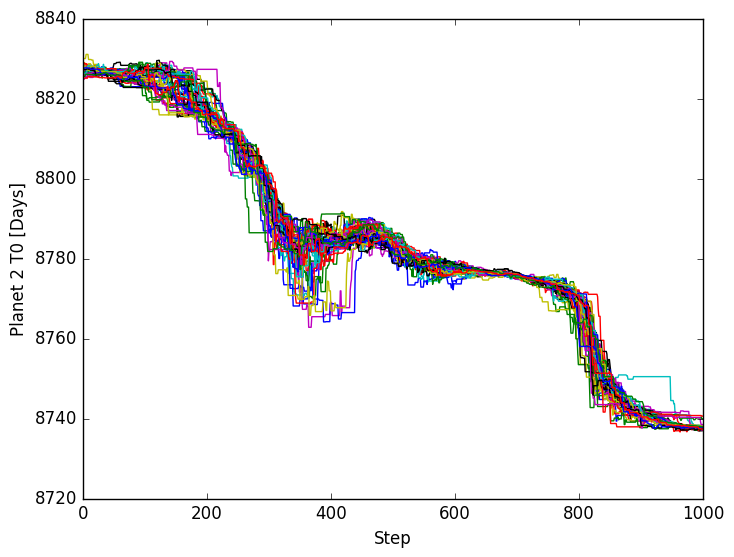

PyObject <matplotlib.text.Text object at 0x7fe95b4a0950>

In [134]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,8]')
end
xlabel("Step")
ylabel("Planet 2 T0 [Days]")

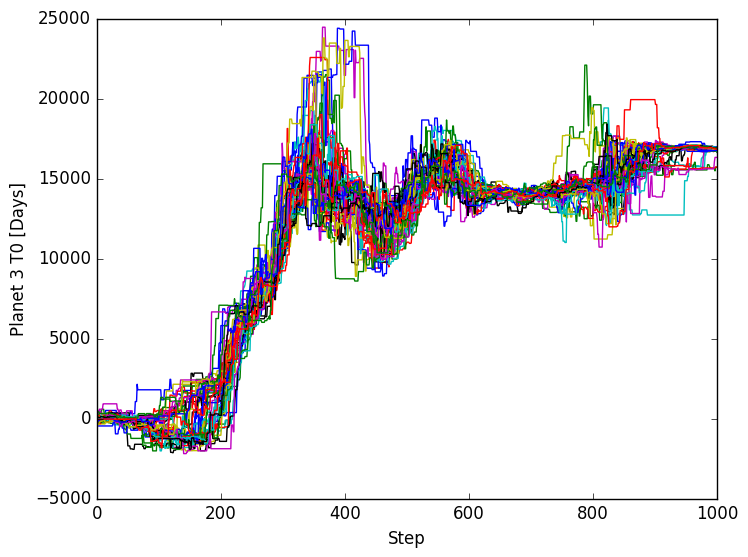

PyObject <matplotlib.text.Text object at 0x7fe95b32ce10>

In [135]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,13]')
end
xlabel("Step")
ylabel("Planet 3 T0 [Days]")

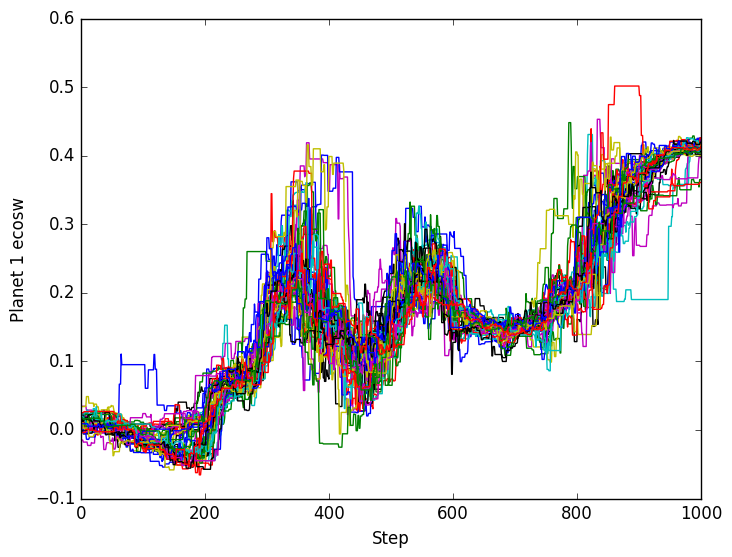

PyObject <matplotlib.text.Text object at 0x7fe95b1642d0>

In [136]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,4]')
end
xlabel("Step")
ylabel("Planet 1 ecosw")

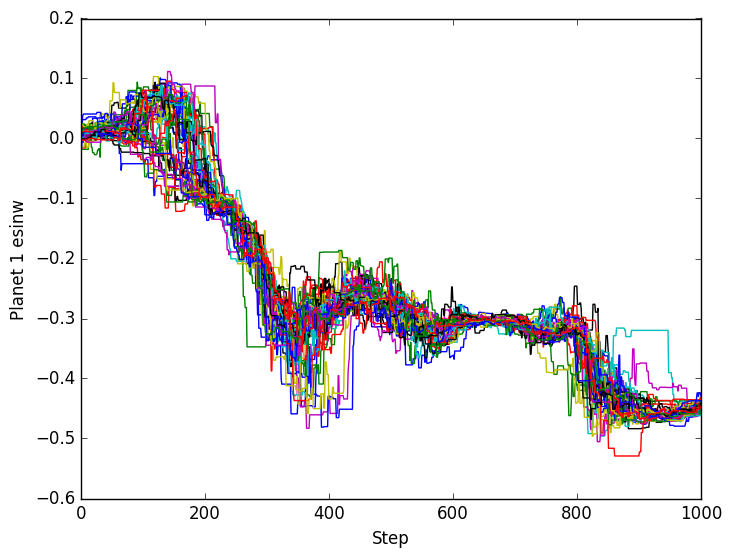

PyObject <matplotlib.text.Text object at 0x7fe95af88510>

In [137]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,5]')
end
xlabel("Step")
ylabel("Planet 1 esinw")

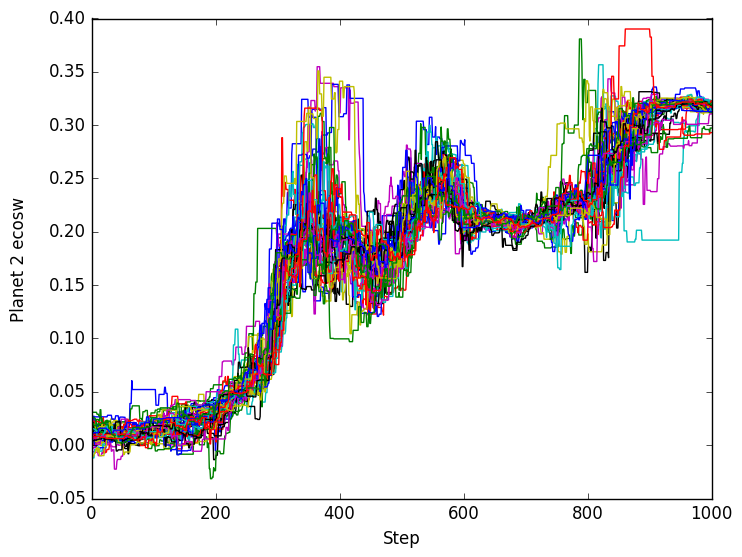

PyObject <matplotlib.text.Text object at 0x7fe95adb9690>

In [138]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,9]')
end
xlabel("Step")
ylabel("Planet 2 ecosw")

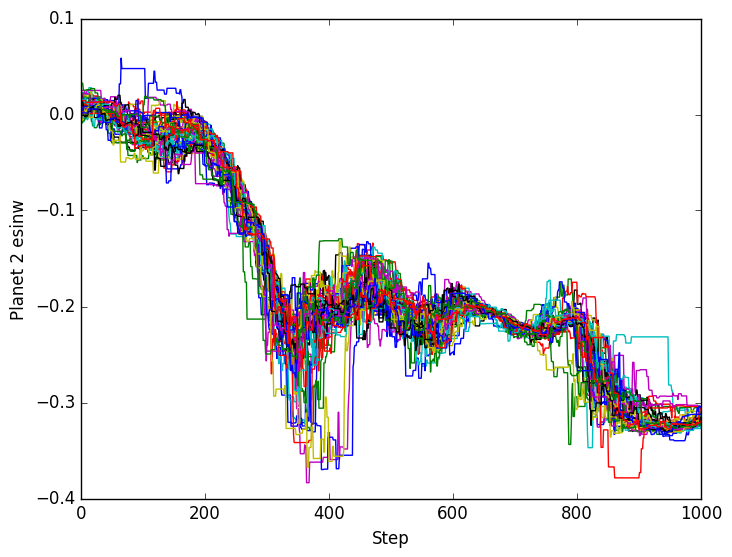

PyObject <matplotlib.text.Text object at 0x7fe95ac63350>

In [139]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,10]')
end
xlabel("Step")
ylabel("Planet 2 esinw")

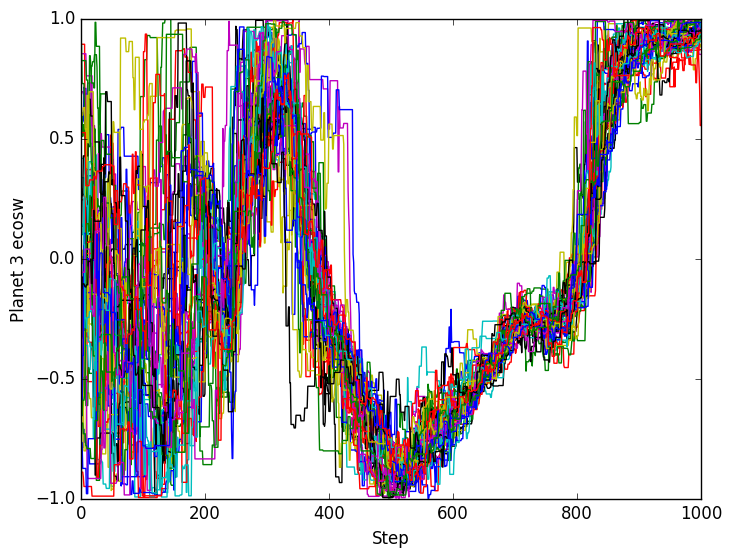

PyObject <matplotlib.text.Text object at 0x7fe95aa80550>

In [140]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,14]')
end
xlabel("Step")
ylabel("Planet 3 ecosw")

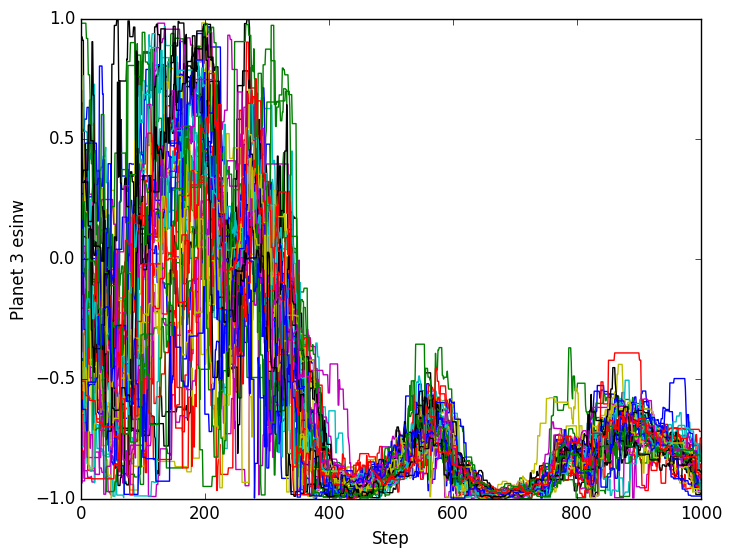

PyObject <matplotlib.text.Text object at 0x7fe95a91b3d0>

In [141]:
steps = collect(linspace(1,1000,1000))
for i in 1:45
    plot(steps,mcmc1[i,:,15]')
end
xlabel("Step")
ylabel("Planet 3 esinw")